In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv("data.csv",encoding="cp1252")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [51]:
df.shape

(541909, 8)

In [52]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [54]:
grouped = df.groupby("CustomerID").count()
grouped

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
CustomerID,,,,,,,
12346.0,2,2,2,2,2,2,2
12347.0,182,182,182,182,182,182,182
12348.0,31,31,31,31,31,31,31
12349.0,73,73,73,73,73,73,73
12350.0,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...
18280.0,10,10,10,10,10,10,10
18281.0,7,7,7,7,7,7,7
18282.0,13,13,13,13,13,13,13


In [55]:
# Data Preprocessing 
df["is_return"] = df["InvoiceNo"].astype(str).str.startswith("C")
df["Description"] = df["Description"].fillna("Unknown")

In [56]:
sales = df[(~df['is_return']) & (df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

In [57]:
# Exploratory data Analysis

sales.head()
sales["Revenue"] = sales["UnitPrice"] * sales["Quantity"]
audit = {
    'rows_total' : sales["CustomerID"].isna().sum(),
    'rows_pct' : df["CustomerID"].isna().sum() / len(df["CustomerID"]),
    'Total_revenue' : np.sum(sales["Revenue"]),
    'rev_avg' : np.mean(sales["Revenue"])
}



audit['rev_null'] = float(sales.loc[sales['CustomerID'].isna(), 'Revenue'].sum())
audit['rev_null_pct'] = round(100 * audit['rev_null'] / audit['Total_revenue'], 2) if audit['Total_revenue'] else 0

print(audit)

{'rows_total': np.int64(132220), 'rows_pct': np.float64(0.249266943342886), 'Total_revenue': np.float64(10666684.544), 'rev_avg': np.float64(20.121871451639677), 'rev_null': 1755276.64, 'rev_null_pct': np.float64(16.46)}


In [58]:
print(sales.groupby(['Country'])['Revenue'].sum().reset_index())

                 Country      Revenue
0              Australia   138521.310
1                Austria    10198.680
2                Bahrain      754.140
3                Belgium    41196.340
4                 Brazil     1143.600
5                 Canada     3666.380
6        Channel Islands    20450.440
7                 Cyprus    13590.380
8         Czech Republic      826.740
9                Denmark    18955.340
10                  EIRE   283453.960
11    European Community     1300.250
12               Finland    22546.080
13                France   209715.110
14               Germany   228867.140
15                Greece     4760.520
16             Hong Kong    15691.800
17               Iceland     4310.000
18                Israel     8135.260
19                 Italy    17483.240
20                 Japan    37416.370
21               Lebanon     1693.880
22             Lithuania     1661.060
23                 Malta     2725.590
24           Netherlands   285446.340
25          

In [59]:
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], errors='coerce')

In [60]:

inv = (sales.groupby(['InvoiceNo', 'CustomerID', 'Country'], dropna=False)
             .agg(InvoiceDate = ('InvoiceDate', 'max'),
                  Lines       = ('StockCode', 'count'),
                  Items       = ('Quantity', 'sum'),
                  Total_rev    = ('Revenue', 'sum'))
             .reset_index())
inv['CustomerType'] = np.where(inv['CustomerID'].isna(), 'Anonymous', 'Known')
inv['Month'] = inv['InvoiceDate'].dt.to_period('M').astype(str)
snapshot_date = inv['InvoiceDate'].max() + pd.Timedelta(days=1)


In [61]:
audit = (
    inv.groupby('CustomerType')
       .agg(invoices=('InvoiceNo', 'nunique'),
            revenue=('Total_rev', 'sum'),
            avg_invoice_value=('Total_rev', 'mean'))
       .reset_index()
)
audit['revenue_share_%'] = 100 * audit['revenue'] / audit['revenue'].sum()
audit

,CustomerType,invoices,revenue,avg_invoice_value,revenue_share_%
0,Anonymous,1428,1755276.640,1229.185322,16.455691
1,Known,18532,8911407.904,480.865956,83.544309


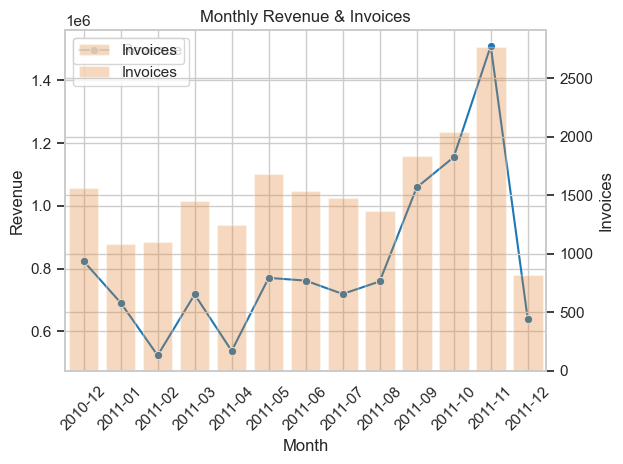

In [62]:
monthly = (inv.groupby(['Month'])
             .agg(Revenue=('Total_rev','sum'),
                  Invoices=('InvoiceNo','nunique'))
             .reset_index())

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(data=monthly, x='Month', y='Revenue', marker='o', ax=ax1, color='#1f77b4', label='Revenue')
sns.barplot(data=monthly, x='Month', y='Invoices', alpha=0.3, ax=ax2, color='#ff7f0e', label='Invoices')

ax1.set_title('Monthly Revenue & Invoices')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue')
ax2.set_ylabel('Invoices')
ax1.tick_params(axis='x', rotation=45)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
plt.show()

In [63]:

df['Revenue'] = df['Quantity'] * df['UnitPrice']
# Convert CustomerID to str


In [64]:

# 1) Force-parse InvoiceDate to datetime (handles dd/mm/yyyy hh:mm formats)
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    errors='coerce',
    dayfirst=True,                # your data is day-first (e.g., 12/1/2010)
    infer_datetime_format=True
)


C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\3842543633.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['InvoiceDate'] = pd.to_datetime(


In [65]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Revenue': 'sum'                                          # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,NaN,2,0.00
1,12347.0,96.0,7,4310.00
2,12348.0,221.0,4,1797.24
3,12349.0,NaN,1,1757.55
4,12350.0,312.0,1,334.40


In [66]:
rfm["Recency"] = rfm["Recency"].fillna(0)
rfm.isna().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

In [67]:
rfm = rfm.dropna(subset=['Recency','Frequency','Monetary'])
rfm = rfm[(rfm['Frequency'] > 0) & (rfm['Monetary'] > 0) & (rfm['Recency'] >0)]

In [68]:
from sklearn.preprocessing import StandardScaler
X = rfm[["Recency", "Frequency", "Monetary"]].copy()
X_log = np.log1p(X)  # avoids log(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X)


In [70]:
cluster_profile = (
    rfm.groupby('Cluster')[["Recency","Frequency","Monetary"]]
    .mean()
    .round(2)
    .assign(Customers = rfm.groupby('Cluster')
    ['CustomerID'].nunique())
    .reset_index()
)

cluster_profile

,Cluster,Recency,Frequency,Monetary,Customers
0,0,149.09,5.80,1708.02,3057
1,1,32.33,64.67,241136.56,3
2,2,46.09,52.39,37238.81,33
3,3,20.00,96.50,114451.90,4


C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\3786019978.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=melted, x='Cluster', y='MeanValue', hue='Metric', palette=palette)


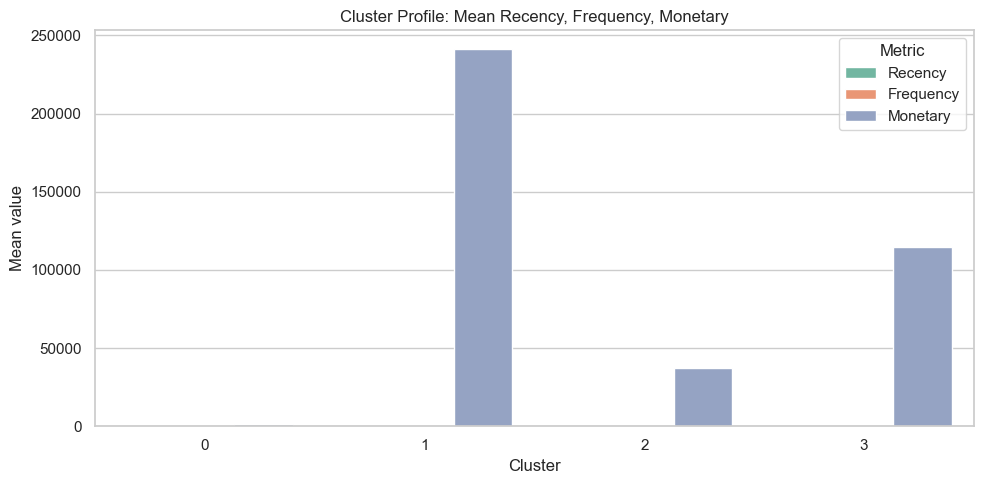

C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\3786019978.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x='Cluster', y='Customers', palette=palette)
C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\3786019978.py:21: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=cluster_profile, x='Cluster', y='Customers', palette=palette)


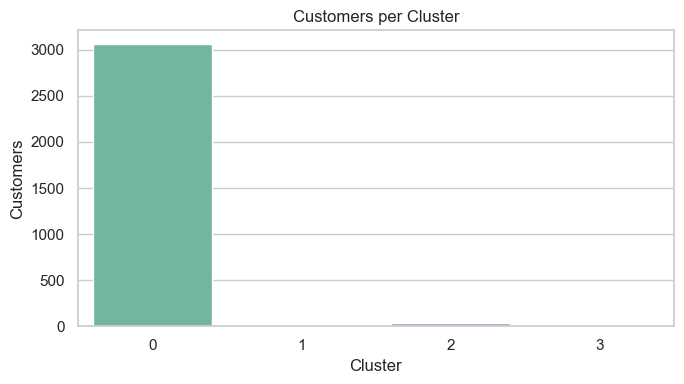

In [71]:

sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# --- a) Average R, F, M by Cluster ---
melted = (cluster_profile
          .melt(id_vars=['Cluster','Customers'],
                value_vars=['Recency','Frequency','Monetary'],
                var_name='Metric', value_name='MeanValue'))

plt.figure(figsize=(10,5))
sns.barplot(data=melted, x='Cluster', y='MeanValue', hue='Metric', palette=palette)
plt.title('Cluster Profile: Mean Recency, Frequency, Monetary')
plt.xlabel('Cluster')
plt.ylabel('Mean value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# --- b) Size of each cluster (number of customers) ---
plt.figure(figsize=(7,4))
sns.barplot(data=cluster_profile, x='Cluster', y='Customers', palette=palette)
plt.title('Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
plt.tight_layout()
plt.show()


C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\3127118954.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='Revenue', y='Country', palette='Blues_r')


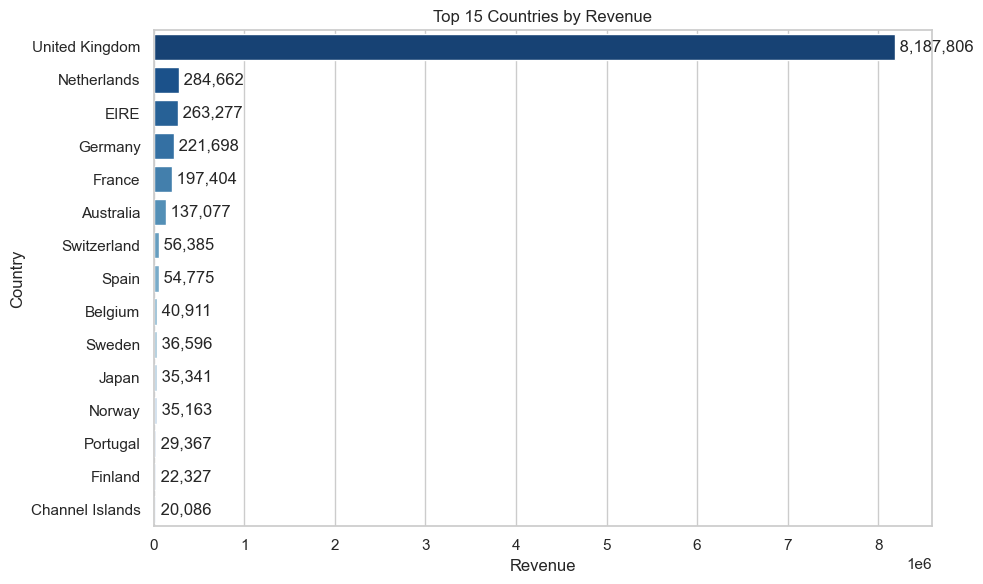

In [72]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Aggregate and sort
country_rev = (df.groupby('Country', as_index=False)['Revenue']
                    .sum()
                    .sort_values('Revenue', ascending=False))

# Choose how many to show
TOP_N = 15
top = country_rev.head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(data=top, x='Revenue', y='Country', palette='Blues_r')
plt.title(f'Top {TOP_N} Countries by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Country')

# Optional: show value labels
for i, v in enumerate(top['Revenue']):
    plt.text(v, i, f' {v:,.0f}', va='center')

plt.tight_layout()
plt.show()


C:\Users\Neelkanth.aher\AppData\Local\Temp\ipykernel_22688\2297544314.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='Quantity', y='Country', palette='Blues_r')


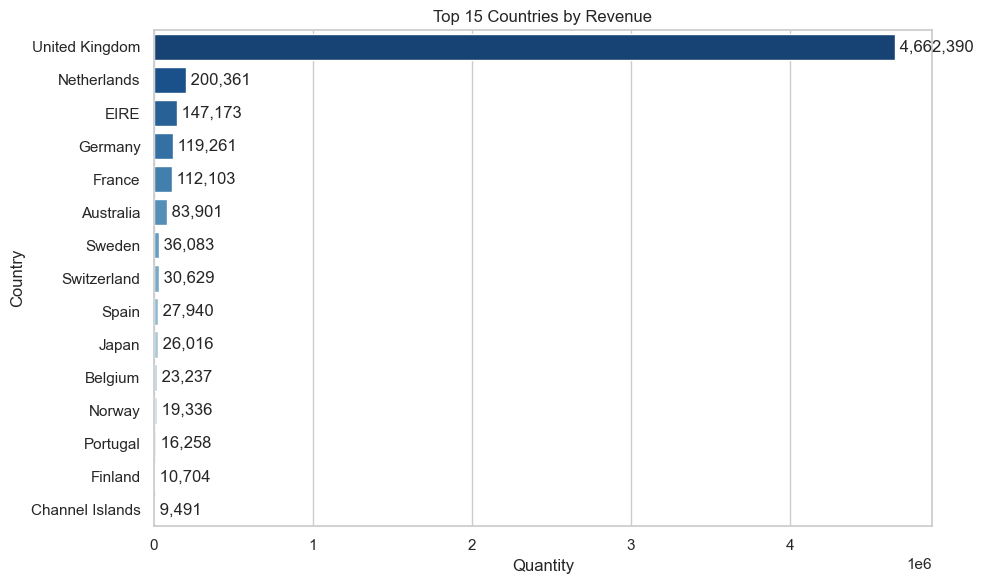

In [78]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Aggregate and sort
country_rev = (sales.groupby('Country', as_index=False)['Quantity']
                    .sum()
                    .sort_values('Quantity', ascending=False))

# Choose how many to show
TOP_N = 15
top = country_rev.head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(data=top, x='Quantity', y='Country', palette='Blues_r')
plt.title(f'Top {TOP_N} Countries by Revenue')
plt.xlabel('Quantity')
plt.ylabel('Country')

# Optional: show value labels
for i, v in enumerate(top['Quantity']):
    plt.text(v, i, f' {v:,.0f}', va='center')

plt.tight_layout()
plt.show()
